# Juno-DKT (Deep Knowledge Tracing)
Scikit-learn style implementation of Deep Knowledge Tracing models based on pytorch.

## 설치 방법
1. 운영체제와 GPU 사용 여부 등을 고려하여 `pytorch`를 설치한다.(https://pytorch.org/get-started/locally/) (Google Colab에서 사용시 생략 가능)
2. 터미널 혹은 명령 프롬프트에서 `pip install juno-dkt`를 실행한다.
3. `juno_dkt`를 import 하여 사용한다. *(pip 패키지 이름은 '-'로 연결되어 있으나, import 할때의 패키지 이름은 '_'로 연결되어 있음에 주의)*

In [4]:
!pip install juno-dkt

## ASSISTment2015 데이터셋에 대한 예제
https://sites.google.com/site/assistmentsdata/home/2015-assistments-skill-builder-data 에서 데이터를 다운로드한 후, 예제 파일과 같은 경로에 `dataset.csv`라는 이름으로 저장한다.

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import juno_dkt as jd
from sklearn.model_selection import train_test_split

df = pd.read_csv('dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708631 entries, 0 to 708630
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      708631 non-null  int64  
 1   log_id       708631 non-null  int64  
 2   sequence_id  708631 non-null  int64  
 3   correct      708631 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 21.6 MB


,user_id,log_id,sequence_id,correct
0,50121,167478035,7014,0.0
1,50121,167478043,7014,1.0
2,50121,167478053,7014,1.0
3,50121,167478069,7014,1.0
4,50964,167478041,7014,1.0


## 1단계. 데이터 형태 변환하기

pandas로 읽어들인 학생의 문항반응 데이터를 DKT모델에 입력하기 위해서는 
`ItemEncoder` Class 를 사용하여 데이터의 형식을 변환해야 한다.


### ItemEncoder Class
명목형으로 된 학생 id, 문항 id, 정오답 여부에 대한 데이터를 one-hot encoding한 후 `torch.Tensor`의 `list`로 바꿔준다.

**ItemEncoder(n_items=None, binary_only=False)**
* `n_items` _(int, Default:None)_ - 문항 수를 명시적으로 지정해야 할 경우 사용하고, 그렇지 않을 경우 기본값 `None`으로 설정하면 데이터에 의해 결정됨.
* `binary_only` _(bool, Default:False)_ - 문항의 정오답 여부가 이진 값(0 또는 1)인 것만 필터링 할 경우 True로 설정, 그렇지 않을 경우 0.3과 같은 실수 값은 `{0.3정답, 0.6오답}`과 같이 인코딩 됨.

**ItemEncoder.transform(students, items, answers)**

_students, items, answers 파라미터의 길이는 동일해야 함._
* `students` _(list of int or str)_ - 정수형 혹은 문자열로 된 학생들의 id 목록
* `items` _(list of int or str)_ - 정수형 혹은 문자열로 된 문항이나 작업의 id 목록
* `answers` _(list of float or int)_ 학생의 정오답 여부를 0~1로 나타낸 값의 목록
* **return** `batches` _(list of torch.Tensor)_ - DKT 모델에 직접 입력될 수 있도록 변환된 데이터


In [6]:
encoder = jd.ItemEncoder(binary_only=True)
batches = encoder.transform(df.user_id, df.sequence_id, df.correct)

[1/3] One-hot encoding item responces...


  0%|          | 0/683801 [00:00<?, ?it/s]

[2/3] Batchifying one-hot vectors...


  0%|          | 0/683801 [00:00<?, ?it/s]

[3/3] Converting type into torch.Tensor...


  0%|          | 0/19840 [00:00<?, ?it/s]

Number of batches(students) :  19840


이 예제에서는 선행연구 [Pandey, S., & Karypis, G. (2019). A self-attentive model for knowledge tracing. arXiv preprint arXiv:1907.06837.](https://arxiv.org/pdf/1907.06837.pdf)에서 사용한 설정을 참고하여 테스트집합 비율을 20%로 분할한다.

In [7]:
trainset, testset = train_test_split(batches, test_size=0.2)

## 2단계. 모델 정의하고 학습시키기

DKT 모델의 파라미터를 설정하고 학습을 시작한다.

### DKT Class

**DKT(n_hidden, batch_size, lr, n_embedding=None, device='cpu')**

_[Deep knowledge tracing (Piech, Chris, et al., 2015)](https://arxiv.org/pdf/1506.05908.pdf)에 기초한 모델을 생성한다. Adam optimizer를 사용하여 학습된다._
* `n_hidden` _(int)_ - 모델의 시계열 분석에 활용되는 LSTM의 은닉층 차원
* `batch_size` _(int)_ - 하나의 배치(batch)에 들어갈 데이터의 학생 수
* `lr` _(float)_ - Adam optimizer의 학습률
* `n_embedding` _(int, Default:None)_ - Compressed sensing 방식으로 구현할 때, 입력층의 one-hot vector가 인코딩되는 차원. 기본값인 `None`일 경우 compressed sensing을 사용하지 않고 one-hot vector가 직접 LSTM으로 입력됨.
* `device` _(str, Default:'cpu')_ - 학습 및 추론시 사용할 연산장치. 기본값인 `'cpu'`일 경우 cpu를 사용하고, `'cuda'`일 경우 그래픽카드 사용. _(cuda 버전에 알맞은 pytorch 설치 필요)_

**DKT.fit(batches, n_iter, test_set=None)**

_모델을 주어진 데이터로 학습시키고 평가한다._

* `batches` _(list of torch.Tensor)_ - ItemEncoder에 의해 변환된 학습 데이터
* `n_iter` _(int)_ 전체 데이터를 반복하여 학습할 횟수(epoch)
* `test_set` _(list of torch.Tensor, Default:None)_ - 훈련 과정애서 각각의 epoch이 끝난 후 지표를 평가할 테스트집합. 기본값인 `None`일 경우 평가를 생략함.


In [8]:
# colab에서 cuda를 사용하려는 경우, 런타임 -> 런타임 유형 변경에서 하드웨어 가속기를 GPU로 설정해야 한다.
# cuda를 사용하지 않을 경우 아래의 device 파라미터를 'cpu'로 수정하면 된다.
model = jd.DKT(n_hidden=50, batch_size=64, lr=0.001, device='cuda')
model.fit(trainset, n_iter=10, test_set=testset)

=== Training epoch 1 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.69947  / Binary Cross Entropy 0.57084
=== Training epoch 2 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.71912  / Binary Cross Entropy 0.55365
=== Training epoch 3 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.72314  / Binary Cross Entropy 0.54380
=== Training epoch 4 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.72821  / Binary Cross Entropy 0.54736
=== Training epoch 5 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.72776  / Binary Cross Entropy 0.54514
=== Training epoch 6 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.72990  / Binary Cross Entropy 0.54727
=== Training epoch 7 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.72965  / Binary Cross Entropy 0.54294
=== Training epoch 8 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.73092  / Binary Cross Entropy 0.54621
=== Training epoch 9 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.73081  / Binary Cross Entropy 0.54506
=== Training epoch 10 ===


  0%|          | 0/248 [00:00<?, ?it/s]

Test score :  ROC AUC 0.73081  / Binary Cross Entropy 0.54050


현재 GPU의 메모리 자원이 충분한지 여부는 `!nvidia-smi`명령어로 확인할 수 있다.

In [9]:
!nvidia-smi

Tue Aug 17 02:33:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    39W /  70W |   1412MiB / 15109MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3단계. 모델 성능 분석하기

**DKT.roc_auc_score(batches)**

_데이터에 대한 ROC AUC(수신자 조작 특성 곡선의 밑넓이) 점수를 반환함_
* `batches` _(list of torch.Tensor)_ - ItemEncoder에 의해 변환된 데이터
* **return** _(float)_ - ROC AUC 점수

**DKT.bce_score(batches)**

_데이터에 대한 binary cross entropy 점수를 반환함_
* `batches` _(list of torch.Tensor)_ - ItemEncoder에 의해 변환된 데이터
* **return** _(float)_ - Binary cross entropy 점수

In [10]:
print('AUC 점수 (훈련집합) : ', model.roc_auc_score(trainset))
print('AUC 점수 (테스트집합) : ', model.roc_auc_score(testset))
print('BCE 점수 (훈련집합) : ', model.bce_score(trainset))
print('BCE 점수 (테스트집합) : ', model.bce_score(testset))

AUC 점수 (훈련집합) :  0.7381192452977724
AUC 점수 (테스트집합) :  0.7308118710757615
BCE 점수 (훈련집합) :  0.5404535
BCE 점수 (테스트집합) :  0.54049575


ROC(Receiver operating charicteristics) 곡선을 직접 그리고 싶을 경우, 아래 메소드를 사용하면 된다.

**DKT.y_true_and_score(batches)**

_데이터에 대해 참값과 예측값을 반환함_
* `batches` _(list of torch.Tensor)_ - ItemEncoder에 의해 변환된 데이터
* **return** `y_true, y_score` _(np.ndarray, np.ndarray)_ - 입력된 데이터의 정오답 참값과 예측값에 대해 나열된 `np.ndarray`형태의 데이터

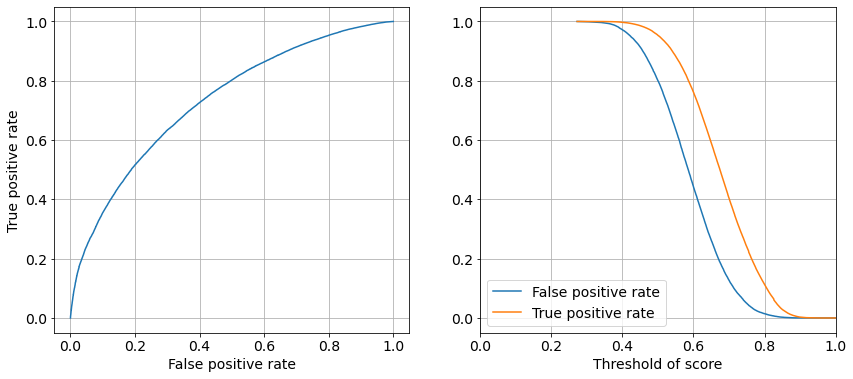

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
plt.rcParams.update({'font.size': 14}) # 폰트 크게

y_true, y_score = model.y_true_and_score(testset)
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()

plt.subplot(122)
plt.plot(thresholds, fpr)
plt.plot(thresholds, tpr)
plt.xlim(0, 1)
plt.xlabel('Threshold of score')
plt.legend(['False positive rate', 'True positive rate'])
plt.grid()
plt.show()

## 4단계. 모델 활용하기

### 개별 학생의 문항반응 예측 변화 관찰

각 문제를 푸는 과정에서 학생의 문항반응에 대한 예측이 어떻게 변화하는지를 관찰하기 위해서는 `DKT.predict` 메소드를 사용하면 된다. 하나의 학생에 대해서 구할 수도 있고, test set 전체 batch를 넣을 수도 있다. 이 예제에서는 test set의 첫번째에 위치한 학생에 대해 관찰했다.

**DKT.predict(data)**
* `data` _(list of torch.Tensor, or torch.Tensor)_ - ItemEncoder로 변환된 학생 데이터의 리스트, 혹은 개별 학생의 데이터.
* **return** `predictions` _(list of np.ndarray, or np.ndarray)_ - 문항반응 예측의 변화를 나타낸 개별 `np.ndarray` 혹은 그 리스트. 각 학생에 대한 `np.ndarray`는 (학생의 응답 수, 전체 문항수)의 크기를 가진다.

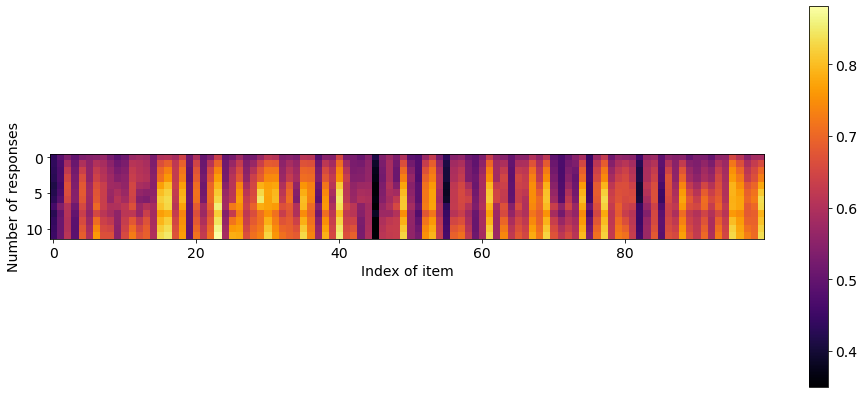

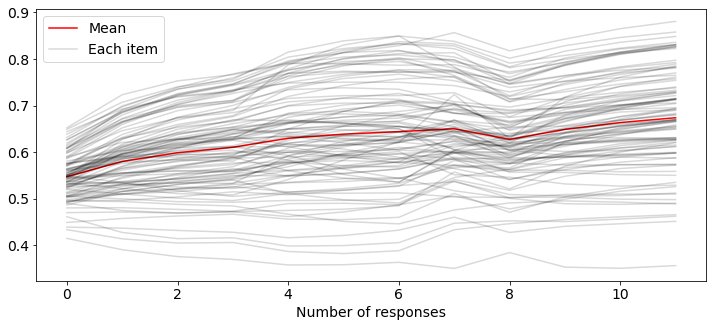

In [25]:
import random

pred = model.predict( testset[ random.randint(0, len(testset)-1 ) ] )
plt.figure(figsize=(16,7))
plt.imshow(pred, cmap=plt.cm.inferno)
plt.xlabel('Index of item')
plt.ylabel('Number of responses')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(np.mean(pred,axis=1), c='red')
plt.plot(pred, c='black', alpha=0.15)
plt.legend(['Mean', 'Each item'])
plt.xlabel('Number of responses')
plt.show()

### 문항간 관계 관찰

[Deep knowledge tracing (Piech, Chris, et al., 2015)](https://arxiv.org/pdf/1506.05908.pdf)에 의하면, 문항 $i$에 대해 처음 정답으로 응답했을 때 모델이 예측한 문항 $j$의 점수를 $y(j|i)$라 할때, 문항 $i$의 $j$에 대한 영향(influence) $J_{ij}$ 는 다음과 같이 정의된다.

$$ J_{ij} = \frac {y(j|i)} {\sum_{k}y(j|k)} $$


**DKT.influence_matrix()**

_모델의 연관 행렬을 `np.ndarray` 형식으로 반환한다._
* **return** `matrix` _(np.ndarray)_ - 연관 행렬 $J$

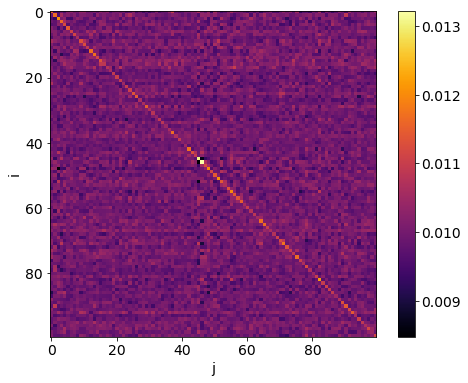

In [13]:
mat = model.influence_matrix()
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap=plt.cm.inferno)
plt.xlabel('j')
plt.ylabel('i')
plt.colorbar()
plt.show()

[지식 공간 (Knowledge space)](https://en.wikipedia.org/wiki/Knowledge_space)의 그래프 구조에 대한 추정은 다음 메소드로 할 수 있다.

**DKT.graph(item_encoder, method='conditional', use_label=False, threshold=0.1, pair_threshold=0)**

_모델의 지식 공간의 그래프를 `networkx.DiGraph` 형식으로 반환한다._
* `item_encoder` *(ItemEncoder)* - 데이터를 변환할 때 사용된 `ItemEncoder` 객체
* `method` _(str, Default:'conditional')_ - 그래프의 가중치를 부여하는 방법. 기본값인 `'conditional'`일 경우, 한 문항에서 다른 문항으로 전이될 확률(transition probability)에 모델이 추정한 점수를 곱하여 사용. `'transition'`일 경우, 전이 확률만을 사용.
* `use_label` _(bool, Default:False)_ - `ItemEncoder`에 입력된 원본 라벨을 사용할 것인지에 대한 여부. 기본값인 `False`로 설정시, 자연수 인덱스로 대체됨.
* `threshold` _(float, Default:0.1)_ - 그래프의 엣지를 생성하기 위한 임계값. 원본 논문에서는 Khan dataset에 대해 0.1을 사용함.
* `pair_threshold` _(float, Default:0)_ - 엣지가 생성되기 위해 문항의 {A, B} 순서쌍이 가져야 할 최소 빈도. 원본 논문에서는 Khan dataset에 대해 0.01을 사용함.
* **return** `g` _(networkx.DiGraph)_ - 가중치가 부여된 유향 그래프 객체

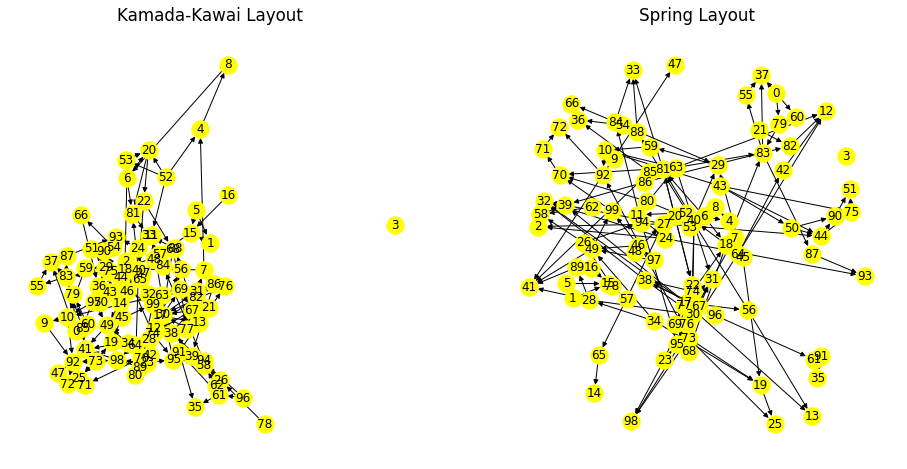

In [24]:
g = model.graph(encoder, method='conditional', threshold=0.05)

plt.figure(figsize=(16,8))

plt.subplot(121)
pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos=pos, node_color='yellow', with_labels=True)
plt.title('Kamada-Kawai Layout')

plt.subplot(122)
pos = nx.spring_layout(g)
nx.draw(g, pos=pos, node_color='yellow', with_labels=True)
plt.title('Spring Layout')
plt.show()